In [13]:
import numpy as np
import scipy
import time
import math
import itertools
from scipy.stats import norm

import mystic
from mystic.solvers import DifferentialEvolutionSolver, diffev2
from mystic.strategy import Best1Bin
from mystic.monitors import Monitor,VerboseMonitor

from copy import deepcopy

from tomography import *

from NestedForLoop import get_iterator
from pathlib import Path
from scipy.linalg import sqrtm

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import os
import glob

import pandas as pd

from scipy.optimize import least_squares

import fnmatch
from efficiencies import finding_file, get_channels_eff, set_raw_counts
from optimization import Optimizer, function_fidelity, FidelityResults
from constants import *

from densitymatrix import DensityMatrix, apply_unitary_to_dm

from pathlib import Path
import fnmatch

Analyse Files:  ['QST_GHZ_20231201103609']
Coincidences column_start: 0 ; column_stop:  16
Channels efficiencies:  [0.78071334 0.77146631 0.90752972 0.82826948 0.89431968 0.87714663
 1.         0.89035667 0.77939234 0.67635403 0.85601057 0.78203435
 0.85204756 0.80184941 0.89035667 0.8348745 ]
Simulating new states considering the uncertainties
Optimizing the fidelity between input and target up to a unitary
file, fidelity, fidelity_mean, fidelity_std:  QST_GHZ_20231201103609\counts (0.66082-0j) 0.64038 0.0 

Analyse Files:  ['QST_GHZ_20231201115216']
Coincidences column_start: 0 ; column_stop:  16
No file containing:  ABCD=zzzz ...
Analyse Files:  ['QST_GHZ_20231201115421']
Coincidences column_start: 0 ; column_stop:  16
Channels efficiencies:  [0.89090909 0.71151515 0.91393939 0.86666667 1.         0.83272727
 0.98181818 0.91151515 0.78666667 0.67878788 0.80606061 0.75636364
 0.97090909 0.74909091 0.99878788 0.82181818]
Simulating new states considering the uncertainties
Optimizing t

C:\Users\Experience\Desktop\Multipartite Entanglement Experiment\Analysis\Tomography\efficiencies.py:84: RuntimeWarning: invalid value encountered in true_divide
  efficiencies=np.sum(efficiencies_aux, 0)/np.max(np.sum(efficiencies_aux, 0))


Analyse Files:  ['QST_GHZ_20231204123750']
Coincidences column_start: 0 ; column_stop:  16
Channels efficiencies:  [0.7985782  0.75829384 0.83649289 0.8056872  0.81990521 0.83175355
 0.92417062 0.88625592 0.77488152 0.73933649 0.8507109  0.91706161
 0.81990521 0.78909953 1.         0.91232227]
Simulating new states considering the uncertainties
Optimizing the fidelity between input and target up to a unitary
file, fidelity, fidelity_mean, fidelity_std:  QST_GHZ_20231204123750\counts (0.76753-0j) 0.75448 0.0 

Analyse Files:  ['QST_GHZ_20231204135356']
Coincidences column_start: 0 ; column_stop:  16
Channels efficiencies:  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
Analyse Files:  ['QST_GHZ_20231204145926']
Coincidences column_start: 0 ; column_stop:  16
Channels efficiencies:  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]


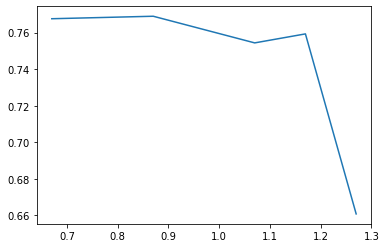

In [15]:

Power = [1.27, 1.17, 1.07,0.87,0.67,0.47]
n_files=0
fidelarr = []
working_dir = os.getcwd()
# os.getcwd()+'\StateTomoData'
working_dir_data = r"C:\Users\Experience\Desktop\Multipartite Entanglement Experiment\Data"
file = "QST"

os.chdir(working_dir_data)

filenames = [i for i in glob.glob(file)]
filenames.sort(key=os.path.getmtime)

index_to_file = {}

for index, filename in enumerate(filenames):
    os.chdir(f"{working_dir_data}\\{filename}")
    filenames_aux=[i for i in glob.glob("QST_GHZ_2023120*")]
    for index_second, filenames_aux_second in enumerate(filenames_aux):
        index_to_file[n_files] = f"{filename}\\{filenames_aux_second}"
        n_files+=1


for v in filenames_aux:
    try:
        
        qubit_number=4
        coincidences_columns = []
        statetomo = []
        state = []
        state_file = []
        xp_counts_corrected_with_eff=[]
        bell=(np.array([1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])+np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]))/np.sqrt(2)
        bellmatrix=np.array(np.outer(bell, np.conjugate(bell)))
        error_runs=1
        U=[]
        bell_aux=[]
        target_ini=[]


        working_dir_data2 = r"C:\Users\Experience\Desktop\Multipartite Entanglement Experiment\Data\QST"
        file2 = f"{v}"
        n_files2=0
        os.chdir(working_dir_data2)

        filenames2 = [i for i in glob.glob(file2)]
        filenames2.sort(key=os.path.getmtime)

        index_to_file2 = {}

        for index2, filename2 in enumerate(filenames2):
            os.chdir(f"{working_dir_data2}\\{filename2}")
            filenames_aux2=[i for i in glob.glob("counts*")]
            for index_second, filenames_aux_second2 in enumerate(filenames_aux2):
                index_to_file2[n_files2] = f"{filename2}\\{filenames_aux_second2}"
                n_files2+=1

        os.chdir(working_dir)
        print("Analyse Files: ", filenames2)
        #####################################################################
        #---------------------- DEFINING PARAMS ----------------------------#
        #####################################################################


        ## Defining the columns of the data file we want to use as data to reconstruct the density matrix (eg.: HH HV VH and VV basis)
        BASIS_TO_CHANNEL={
            "HA": 1,
            "VA": 2,
            "HB": 3,
            "VB": 4,
            "HC": 5,
            "VC": 6,
            "HD": 7,
            "VD": 8,
            }

        ### Bell state ###
        # eigenstates = [['HA','HB'],['HA','VB'],['VA','HB'],['VA','VB']]

        ### 4 qubits GHZ ###
        eigenstates = [['HA','HB','HC','HD'],['HA','HB','HC','VD'],['HA','HB','VC','HD'],['HA','HB','VC','VD'],
                       ['HA','VB','HC','HD'],['HA','VB','HC','VD'],['HA','VB','VC','HD'],['HA','VB','VC','VD'],
                       ['VA','HB','HC','HD'],['VA','HB','HC','VD'],['VA','HB','VC','HD'],['VA','HB','VC','VD'],
                       ['VA','VB','HC','HD'],['VA','VB','HC','VD'],['VA','VB','VC','HD'],['VA','VB','VC','VD']]

        fold = four_fold=[[BASIS_TO_CHANNEL[eigenstates[i][j]] for j in range(qubit_number)] for i in range(len(eigenstates))]
        datafile_channels = fold.copy()

        for clicks in fold:
            not_in_clicks = list(set(range(1, 2*qubit_number+1)) - set(clicks))
            not_in_clicks.sort()
            for rep in range(1, len(not_in_clicks)+1):
                for combo in itertools.combinations(not_in_clicks, rep):
                    new_clicks = clicks + list(combo)
                    new_clicks.sort()
                    datafile_channels.append(new_clicks)

        datafile_channels = np.array(list(set(map(tuple, datafile_channels))), dtype=object)
        first_order = list(map(len, datafile_channels)) 
        order = np.lexsort((datafile_channels, first_order))
        datafile_channels = list(datafile_channels[order])
        datafile_channels = [list(t) for t in datafile_channels]

        for i, iter in enumerate(eigenstates):
            proj = [BASIS_TO_CHANNEL[iter[m]] for m in range(qubit_number)]
            coincidences_columns.append(datafile_channels.index(proj))
        column_start = np.min(coincidences_columns)# + single_channels_offset
        column_stop = np.max(coincidences_columns) + 1# + single_channels_offset
        print("Coincidences column_start:", column_start,"; column_stop: ", column_stop)
        #####################################################################
        #---------------------- STATE TOMOGRAPHY ----------------------------
        #####################################################################

        for index in range(len(index_to_file2)):
            os.chdir(f"{working_dir_data2}\\{index_to_file2[index]}\\")
            datafiles=[i for i in glob.glob("*")]

            ### Calculating the efficiencies of each detector
            efficiencies=get_channels_eff(datafiles, qubit_number, column_start, column_stop, os.getcwd())
        #     efficiencies_2_emissions=get_channels_eff(datafiles, qubit_number, column_start_2_emissions, column_stop_2_emissions, os.getcwd())
            print("Channels efficiencies: ", efficiencies)
        #     print("Channels efficiencies (double emission): ", efficiencies_2_emissions)

            ### Opening the data files and writing the data in counts_aux array
            counts_aux=set_raw_counts(datafiles, qubit_number, column_start, column_stop, os.getcwd())
            xp_counts=np.array(np.transpose(counts_aux))
            total_per_basis=np.sum(xp_counts, axis=1)

            statetomo.append(LRETomography(int(qubit_number), xp_counts))#, xp_counts_2_emissions))
            statetomo[-1].run(correct_eff=efficiencies)#, correct_double_emission_eff=None, correct_double_emission=double_emission_columns)
            xp_counts_corrected_with_eff.append(statetomo[-1].xp_counts)

            state.append(statetomo[-1])
            state_file.append(index_to_file2[index])

            states=state
            fid=np.zeros((n_files))
            optimized_matrix=np.zeros((n_files,2**qubit_number,2**qubit_number), dtype='complex')

            guess=np.zeros(3*(qubit_number-1))
            bounds=[(-np.pi,np.pi)]*3*(qubit_number-1)
            results = []

            opt=Optimizer(guess, function_fidelity, results=FidelityResults)
            for index in range(len(states)):
                result=opt.optimize(qubit_number,states[index].state, bell, bounds=bounds)
                results.append(result)

            states=state
            states_file=state_file
            players=["Arya", "Bran","Cersei","Dany"]

            for index in range(len(states)):
                target=bellmatrix
                U.append(results[index].u)
                target_ini.append(np.transpose(np.conjugate(U[-1]))@bellmatrix@U[-1])    

                states[index].calculate_fidelity_error(players, error_runs, opt, target, optimization=True, bounds=bounds)

                print('file, fidelity, fidelity_mean, fidelity_std: ',
                      states_file[index], np.round(states[index].state.fidelity(target_ini[-1]),5), -np.round(states[index].fidelity_mu,5),
                      np.round(states[index].fidelity_std,5), '\n')
                fidelarr.append(np.round(states[index].state.fidelity(target_ini[-1]),5))
    except :
        pass

plt.plot(Power,np.real(fidelarr))
    